We connect to google drive where the dataset has been stored


In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We import the libraries that we are going to use

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os

In [140]:
labels = ['COVID','NORMAL']

In [141]:
X_train = []
X_test = []
y_train = []
y_test= []
image_size = 150

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/xray_dataset_covid19','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/xray_dataset_covid19','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
        y_test.append(i)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

100%|██████████| 20/20 [00:00<00:00, 38.60it/s]


In [142]:
X_train.shape

(148, 150, 150, 3)

In [143]:
X_test.shape

(40, 150, 150, 3)

In [144]:
y_train.shape

(148,)

In [145]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [146]:
generator = ImageDataGenerator(
    horizontal_flip=True
)

batch_size = X_train.shape[0]

augmented_images = []
augmented_labels = []

for X_batch, y_batch in generator.flow(X_train, y_train, batch_size=batch_size, shuffle=True):
    augmented_images.extend(X_batch)
    augmented_labels.extend(y_batch)
    break  # Since we only need one batch of augmented data

# Convert to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate augmented data to the original dataset
X_train_1 = np.concatenate((X_train, augmented_images), axis=0)
y_train_1 = np.concatenate((y_train, augmented_labels), axis=0)

In [147]:
X_train_1.shape

(296, 150, 150, 3)

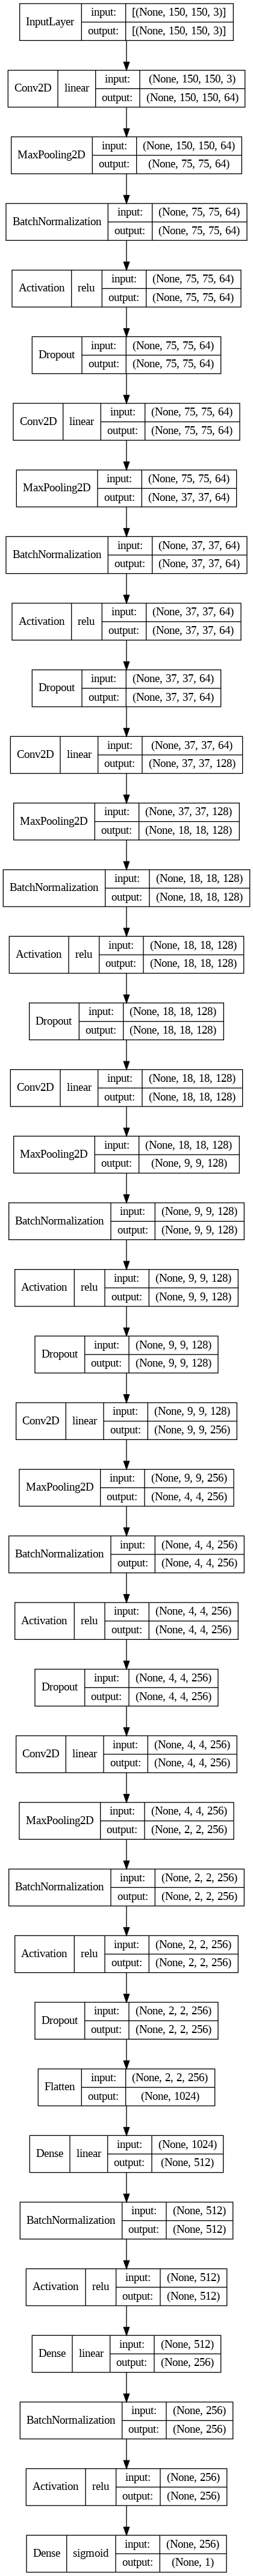

In [148]:
# Define the CNN model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(64, (3, 3), input_shape=(150, 150, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolutional Layer 4
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolutional Layer 5
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Convolutional Layer 6
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Fully Connected Layer 2
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [149]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [150]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [151]:
history = model.fit(X_train_1 , y_train_1, validation_split=0.25, epochs=50, batch_size=32, callbacks=[checkpoint], verbose = 1)

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6937
Epoch 1: val_accuracy improved from -inf to 0.48649, saving model to model/checkpoint
7/7 [==============================] - 10s 710ms/step - loss: 0.6593 - accuracy: 0.6937 - val_loss: 0.6924 - val_accuracy: 0.4865
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9189
Epoch 2: val_accuracy did not improve from 0.48649
7/7 [==============================] - 1s 95ms/step - loss: 0.2662 - accuracy: 0.9189 - val_loss: 0.7123 - val_accuracy: 0.4865
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9505
Epoch 3: val_accuracy did not improve from 0.48649
7/7 [==============================] - 1s 91ms/step - loss: 0.1375 - accuracy: 0.9505 - val_loss: 0.8141 - val_accuracy: 0.4865
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9685
Epoch 4: val_accuracy did not improve from 0.48649
7/7 [==

In [152]:
best = load_model('model/checkpoint')

loss, accuracy = best.evaluate(X_test, y_test, verbose=1)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

2/2 [==============================] - 0s 16ms/step - loss: 0.6958 - accuracy: 0.5000

Testing loss: 0.70, accuracy: 50.00%


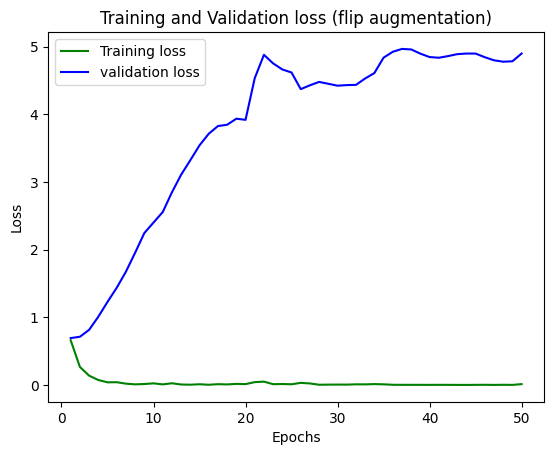

In [153]:
# Plot Training and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss (flip augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

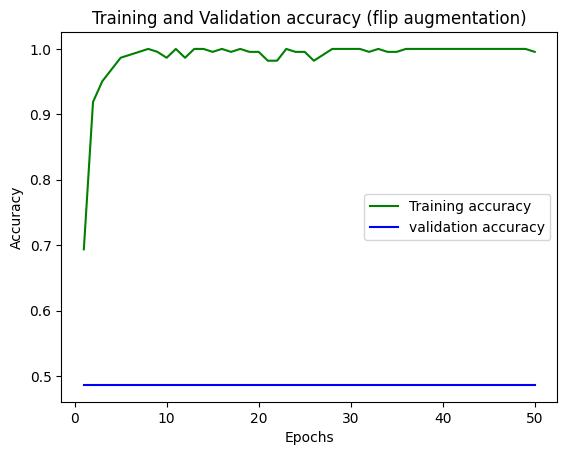

In [154]:

# Plot Training and validation accuracy
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy (flip augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 0s 17ms/step


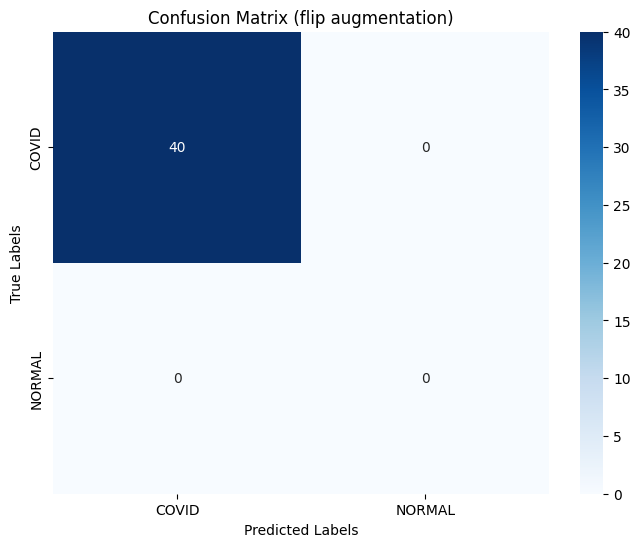

In [85]:
y_pred = best.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred,labels=range(len(labels)))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (flip augmentation)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [86]:
print(classification_report(y_true, y_pred,target_names=labels))

ValueError: ignored

In [87]:
generator = ImageDataGenerator(
    rotation_range=90
)

batch_size = X_train.shape[0]

augmented_images = []
augmented_labels = []

for X_batch, y_batch in generator.flow(X_train, y_train, batch_size=batch_size, shuffle=False):
    augmented_images.extend(X_batch)
    augmented_labels.extend(y_batch)
    break  # Since we only need one batch of augmented data

# Convert to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate augmented data to the original dataset
X_train_2 = np.concatenate((X_train_1, augmented_images), axis=0)
y_train_2 = np.concatenate((y_train_1, augmented_labels), axis=0)

In [88]:
X_train_2.shape

(444, 150, 150, 3)

In [89]:
checkpoint = ModelCheckpoint('model/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [90]:
history = model.fit(X_train_2 , y_train_2, validation_split=0.25, epochs=50, batch_size=32, callbacks=[checkpoint], verbose = 1)

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9940
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to model/checkpoint
11/11 [==============================] - 6s 639ms/step - loss: 0.0311 - accuracy: 0.9940 - val_loss: 5.4773 - val_accuracy: 0.3333
Epoch 2/50
10/11 [==========================>...] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.33333
11/11 [==============================] - 1s 96ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 6.1908 - val_accuracy: 0.3333
Epoch 3/50
10/11 [==========================>...] - ETA: 0s - loss: 0.0100 - accuracy: 0.9969
Epoch 3: val_accuracy did not improve from 0.33333
11/11 [==============================] - 1s 83ms/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 5.9996 - val_accuracy: 0.3333
Epoch 4/50
10/11 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.

In [91]:
best = load_model('model/checkpoint')

loss, accuracy = best.evaluate(X_test, y_test, verbose=1)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

2/2 [==============================] - 0s 15ms/step - loss: 0.2474 - accuracy: 0.9250

Testing loss: 0.25, accuracy: 92.50%


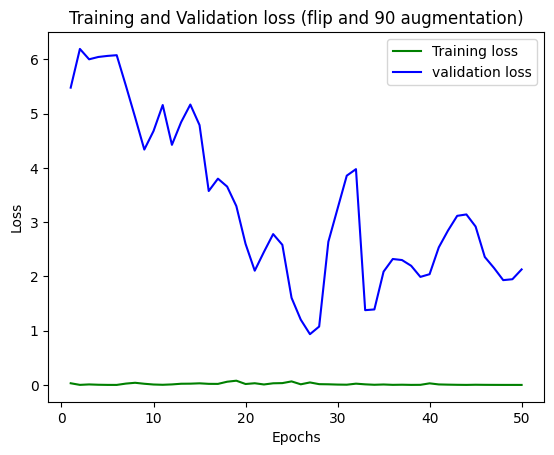

In [92]:
# Plot Training and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss (flip and 90 augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

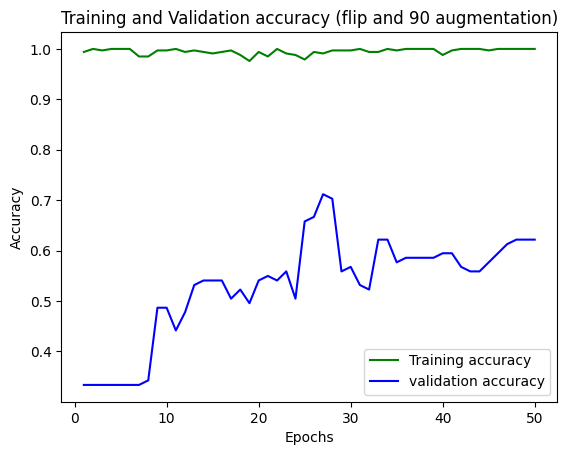

In [93]:
# Plot Training and validation accuracy
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy (flip and 90 augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 0s 15ms/step


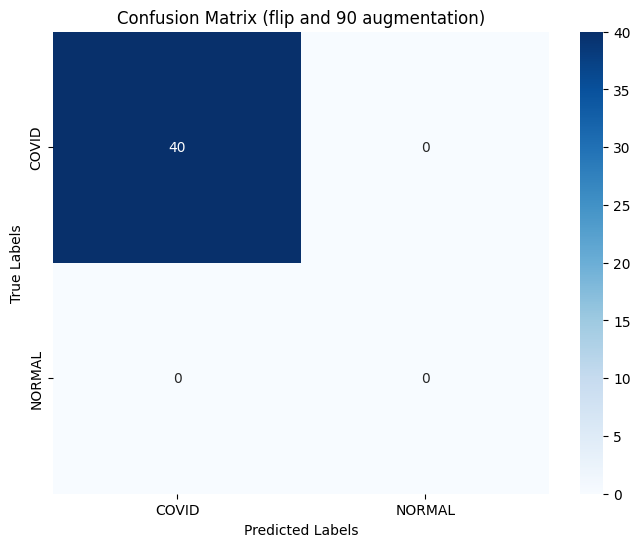

In [94]:
y_pred = best.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred,labels=range(len(labels)))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (flip and 90 augmentation)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [95]:
print(classification_report(y_true, y_pred,target_names=labels))

ValueError: ignored

In [96]:
generator = ImageDataGenerator(
    rotation_range = 180
)

batch_size = X_train.shape[0]

augmented_images = []
augmented_labels = []

for X_batch, y_batch in generator.flow(X_train, y_train, batch_size=batch_size, shuffle=False):
    augmented_images.extend(X_batch)
    augmented_labels.extend(y_batch)
    break  # Since we only need one batch of augmented data

# Convert to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate augmented data to the original dataset
X_train_3 = np.concatenate((X_train_2, augmented_images), axis=0)
y_train_3 = np.concatenate((y_train_2, augmented_labels), axis=0)

In [97]:
X_train_3.shape

(592, 150, 150, 3)

In [98]:
checkpoint = ModelCheckpoint('model/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [99]:
history = model.fit(X_train_3 , y_train_3, validation_split=0.25, epochs=50, batch_size=32, callbacks=[checkpoint], verbose = 1)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8964
Epoch 1: val_accuracy improved from -inf to 0.74324, saving model to model/checkpoint
14/14 [==============================] - 6s 458ms/step - loss: 0.3243 - accuracy: 0.8964 - val_loss: 0.8956 - val_accuracy: 0.7432
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9775
Epoch 2: val_accuracy did not improve from 0.74324
14/14 [==============================] - 1s 93ms/step - loss: 0.0784 - accuracy: 0.9775 - val_loss: 1.9400 - val_accuracy: 0.6824
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9842
Epoch 3: val_accuracy did not improve from 0.74324
14/14 [==============================] - 1s 89ms/step - loss: 0.0460 - accuracy: 0.9842 - val_loss: 1.8978 - val_accuracy: 0.6081
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9887
Epoch 4: val_accuracy did not improve from 0.

In [100]:
best = load_model('model/checkpoint')

loss, accuracy = best.evaluate(X_test, y_test, verbose=1)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

2/2 [==============================] - 0s 20ms/step - loss: 0.1226 - accuracy: 0.9750

Testing loss: 0.12, accuracy: 97.50%


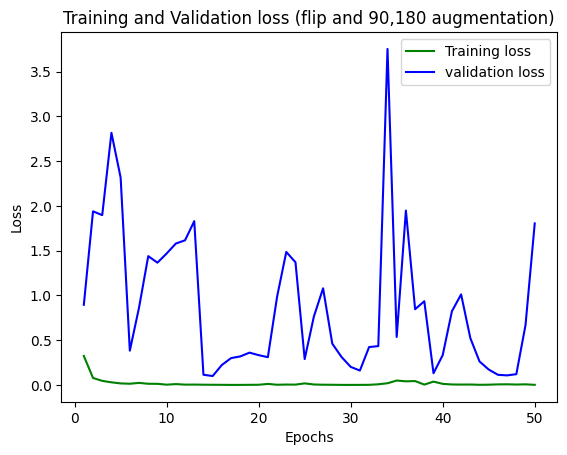

In [101]:
# Plot Training and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss (flip and 90,180 augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

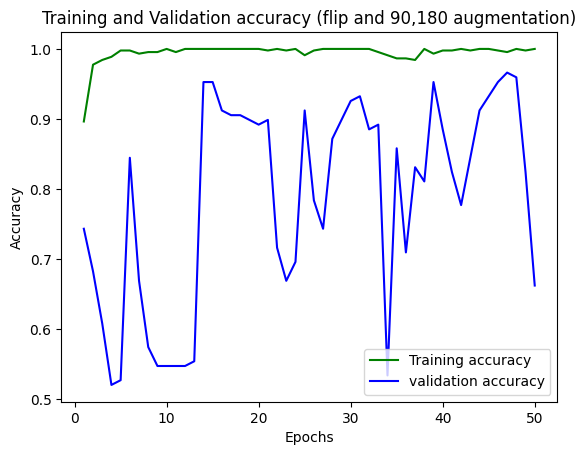

In [102]:
# Plot Training and validation accuracy
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy (flip and 90,180 augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 0s 15ms/step


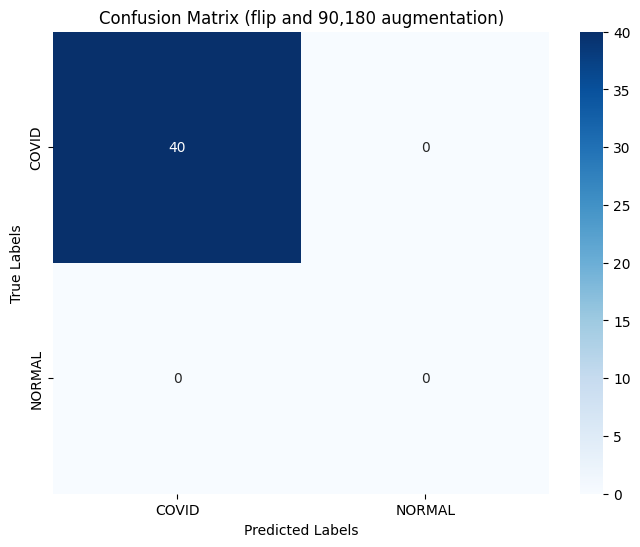

In [103]:
y_pred = best.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred,labels=range(len(labels)))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (flip and 90,180 augmentation)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred,target_names=labels))

In [104]:
generator = ImageDataGenerator(
    rotation_range = 270
)

batch_size = X_train.shape[0]

augmented_images = []
augmented_labels = []

for X_batch, y_batch in generator.flow(X_train, y_train, batch_size=batch_size, shuffle=False):
    augmented_images.extend(X_batch)
    augmented_labels.extend(y_batch)
    break  # Since we only need one batch of augmented data

# Convert to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate augmented data to the original dataset
X_train_4 = np.concatenate((X_train_3, augmented_images), axis=0)
y_train_4 = np.concatenate((y_train_3, augmented_labels), axis=0)

In [105]:
X_train_4.shape

(740, 150, 150, 3)

In [106]:
checkpoint = ModelCheckpoint('model/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [107]:
history = model.fit(X_train_4 , y_train_4, validation_split=0.25, epochs=50, batch_size=32, callbacks=[checkpoint], verbose = 1)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9874
Epoch 1: val_accuracy improved from -inf to 0.70270, saving model to model/checkpoint
18/18 [==============================] - 8s 439ms/step - loss: 0.0349 - accuracy: 0.9874 - val_loss: 1.5515 - val_accuracy: 0.7027
Epoch 2/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0210 - accuracy: 0.9945
Epoch 2: val_accuracy improved from 0.70270 to 0.75135, saving model to model/checkpoint
18/18 [==============================] - 5s 318ms/step - loss: 0.0206 - accuracy: 0.9946 - val_loss: 1.1535 - val_accuracy: 0.7514
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0115 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 0.75135
18/18 [==============================] - 2s 98ms/step - loss: 0.0113 - accuracy: 0.9964 - val_loss: 2.4626 - val_accuracy: 0.6486
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9946
Epoch 

In [108]:
best = load_model('model/checkpoint')

loss, accuracy = best.evaluate(X_test, y_test, verbose=1)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

2/2 [==============================] - 0s 16ms/step - loss: 0.0078 - accuracy: 1.0000

Testing loss: 0.01, accuracy: 100.00%


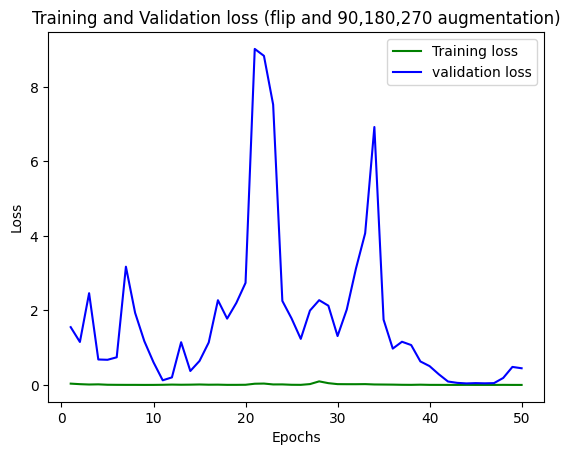

In [109]:
# Plot Training and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss (flip and 90,180,270 augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

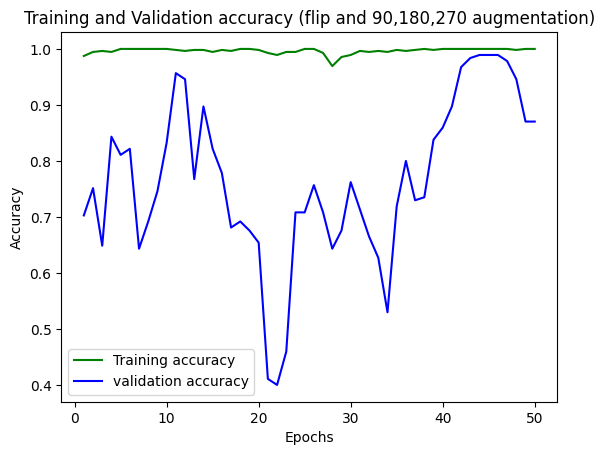

In [110]:
# Plot Training and validation accuracy
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy (flip and 90,180,270 augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 0s 15ms/step


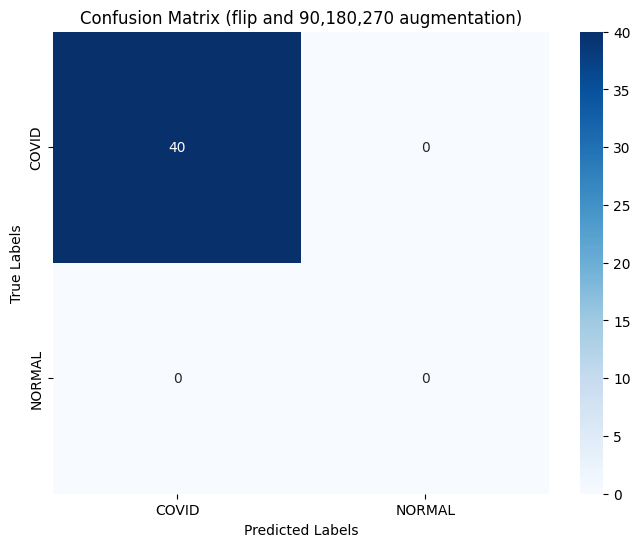

In [111]:
y_pred = best.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred,labels=range(len(labels)))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (flip and 90,180,270 augmentation)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred,target_names=labels))

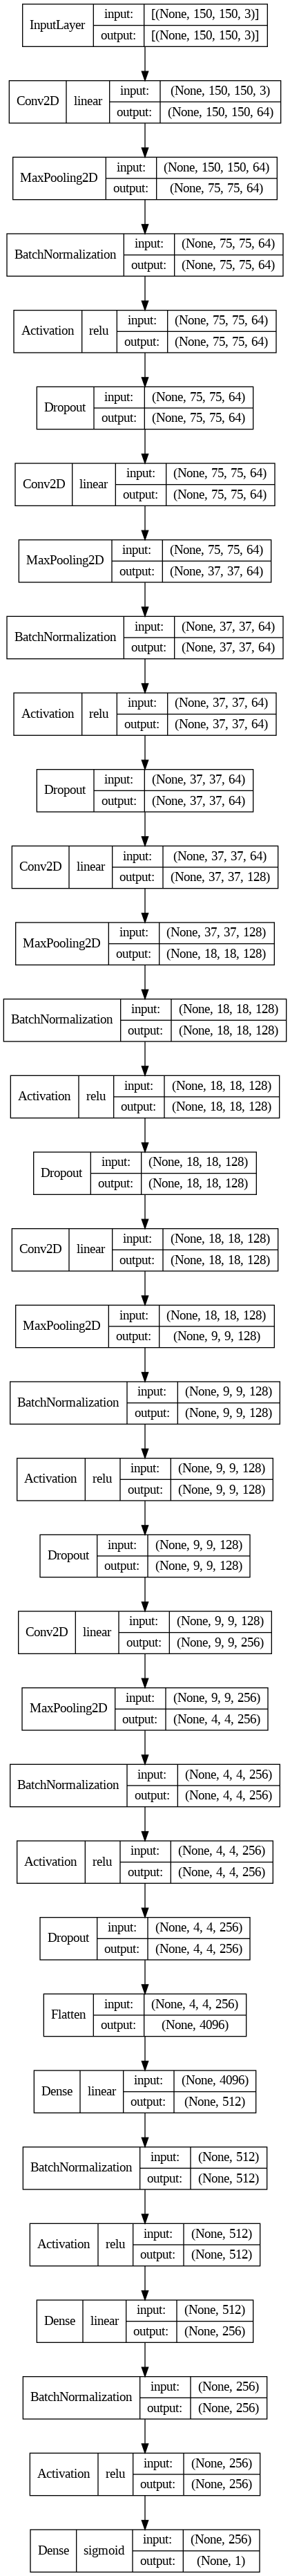

In [112]:
# Define the CNN model
layers_5 = Sequential()

# Convolutional Layer 1
layers_5.add(Conv2D(64, (3, 3), input_shape=(150, 150, 3), padding='same'))
layers_5.add(MaxPooling2D(pool_size=(2, 2)))
layers_5.add(BatchNormalization())
layers_5.add(Activation('relu'))
layers_5.add(Dropout(0.2))

# Convolutional Layer 2
layers_5.add(Conv2D(64, (3, 3), padding='same'))
layers_5.add(MaxPooling2D(pool_size=(2, 2)))
layers_5.add(BatchNormalization())
layers_5.add(Activation('relu'))
layers_5.add(Dropout(0.2))

# Convolutional Layer 3
layers_5.add(Conv2D(128, (3, 3), padding='same'))
layers_5.add(MaxPooling2D(pool_size=(2, 2)))
layers_5.add(BatchNormalization())
layers_5.add(Activation('relu'))
layers_5.add(Dropout(0.2))

# Convolutional Layer 4
layers_5.add(Conv2D(128, (3, 3), padding='same'))
layers_5.add(MaxPooling2D(pool_size=(2, 2)))
layers_5.add(BatchNormalization())
layers_5.add(Activation('relu'))
layers_5.add(Dropout(0.2))

# Convolutional Layer 5
layers_5.add(Conv2D(256, (3, 3), padding='same'))
layers_5.add(MaxPooling2D(pool_size=(2, 2)))
layers_5.add(BatchNormalization())
layers_5.add(Activation('relu'))
layers_5.add(Dropout(0.2))

# Flatten Layer
layers_5.add(Flatten())

# Fully Connected Layer 1
layers_5.add(Dense(512))
layers_5.add(BatchNormalization())
layers_5.add(Activation('relu'))

# Fully Connected Layer 2
layers_5.add(Dense(256))
layers_5.add(BatchNormalization())
layers_5.add(Activation('relu'))

# Output Layer
layers_5.add(Dense(1, activation='sigmoid'))

plot_model(layers_5, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [113]:
checkpoint_layers_5 = ModelCheckpoint('layers_5/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [114]:
layers_5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [115]:
history = layers_5.fit(X_train_4 , y_train_4, validation_split=0.25, epochs=50, batch_size=32, callbacks=[checkpoint_layers_5], verbose = 1)

Epoch 1/50
17/18 [===========================>..] - ETA: 0s - loss: 0.4272 - accuracy: 0.8125
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to layers_5/checkpoint
18/18 [==============================] - 11s 285ms/step - loss: 0.4218 - accuracy: 0.8162 - val_loss: 0.8891 - val_accuracy: 0.4000
Epoch 2/50
17/18 [===========================>..] - ETA: 0s - loss: 0.1477 - accuracy: 0.9449
Epoch 2: val_accuracy did not improve from 0.40000
18/18 [==============================] - 2s 87ms/step - loss: 0.1455 - accuracy: 0.9459 - val_loss: 2.0764 - val_accuracy: 0.4000
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0610 - accuracy: 0.9798
Epoch 3: val_accuracy did not improve from 0.40000
18/18 [==============================] - 2s 89ms/step - loss: 0.0605 - accuracy: 0.9802 - val_loss: 3.5693 - val_accuracy: 0.4000
Epoch 4/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0506 - accuracy: 0.9816
Epoch 4: val_accuracy did not improve fro

In [116]:
best_layers_5 = load_model('layers_5/checkpoint')

loss, accuracy = best.evaluate(X_test, y_test, verbose=1)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

2/2 [==============================] - 0s 13ms/step - loss: 0.0078 - accuracy: 1.0000

Testing loss: 0.01, accuracy: 100.00%


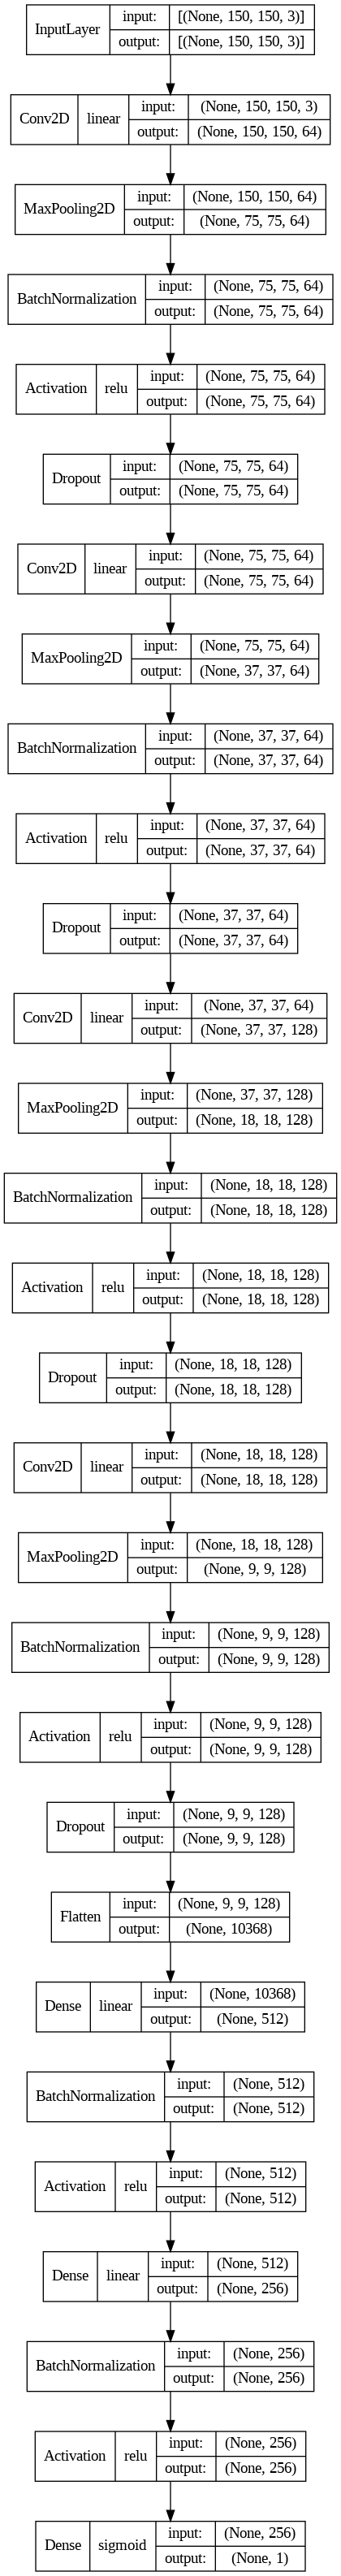

In [117]:
# Define the CNN model
layers_4 = Sequential()

# Convolutional Layer 1
layers_4.add(Conv2D(64, (3, 3), input_shape=(150, 150, 3), padding='same'))
layers_4.add(MaxPooling2D(pool_size=(2, 2)))
layers_4.add(BatchNormalization())
layers_4.add(Activation('relu'))
layers_4.add(Dropout(0.2))

# Convolutional Layer 2
layers_4.add(Conv2D(64, (3, 3), padding='same'))
layers_4.add(MaxPooling2D(pool_size=(2, 2)))
layers_4.add(BatchNormalization())
layers_4.add(Activation('relu'))
layers_4.add(Dropout(0.2))

# Convolutional Layer 3
layers_4.add(Conv2D(128, (3, 3), padding='same'))
layers_4.add(MaxPooling2D(pool_size=(2, 2)))
layers_4.add(BatchNormalization())
layers_4.add(Activation('relu'))
layers_4.add(Dropout(0.2))

# Convolutional Layer 4
layers_4.add(Conv2D(128, (3, 3), padding='same'))
layers_4.add(MaxPooling2D(pool_size=(2, 2)))
layers_4.add(BatchNormalization())
layers_4.add(Activation('relu'))
layers_4.add(Dropout(0.2))

# Flatten Layer
layers_4.add(Flatten())

# Fully Connected Layer 1
layers_4.add(Dense(512))
layers_4.add(BatchNormalization())
layers_4.add(Activation('relu'))

# Fully Connected Layer 2
layers_4.add(Dense(256))
layers_4.add(BatchNormalization())
layers_4.add(Activation('relu'))

# Output Layer
layers_4.add(Dense(1, activation='sigmoid'))

plot_model(layers_4, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [118]:
checkpoint_layers_4 = ModelCheckpoint('layers_4/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [119]:
layers_4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [120]:
history = layers_4.fit(X_train_4 , y_train_4, validation_split=0.25, epochs=50, batch_size=32, callbacks=[checkpoint_layers_4], verbose = 1)

Epoch 1/50
17/18 [===========================>..] - ETA: 0s - loss: 0.3409 - accuracy: 0.8364
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to layers_4/checkpoint
18/18 [==============================] - 9s 344ms/step - loss: 0.3380 - accuracy: 0.8378 - val_loss: 1.0930 - val_accuracy: 0.4000
Epoch 2/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0743 - accuracy: 0.9743
Epoch 2: val_accuracy did not improve from 0.40000
18/18 [==============================] - 2s 85ms/step - loss: 0.0737 - accuracy: 0.9748 - val_loss: 2.5933 - val_accuracy: 0.4000
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0433 - accuracy: 0.9853
Epoch 3: val_accuracy did not improve from 0.40000
18/18 [==============================] - 1s 82ms/step - loss: 0.0558 - accuracy: 0.9802 - val_loss: 4.2973 - val_accuracy: 0.4000
Epoch 4/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0687 - accuracy: 0.9798
Epoch 4: val_accuracy did not improve from

In [121]:
best_layers_4 = load_model('layers_4/checkpoint')

loss, accuracy = best.evaluate(X_test, y_test, verbose=1)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

2/2 [==============================] - 0s 20ms/step - loss: 0.0078 - accuracy: 1.0000

Testing loss: 0.01, accuracy: 100.00%


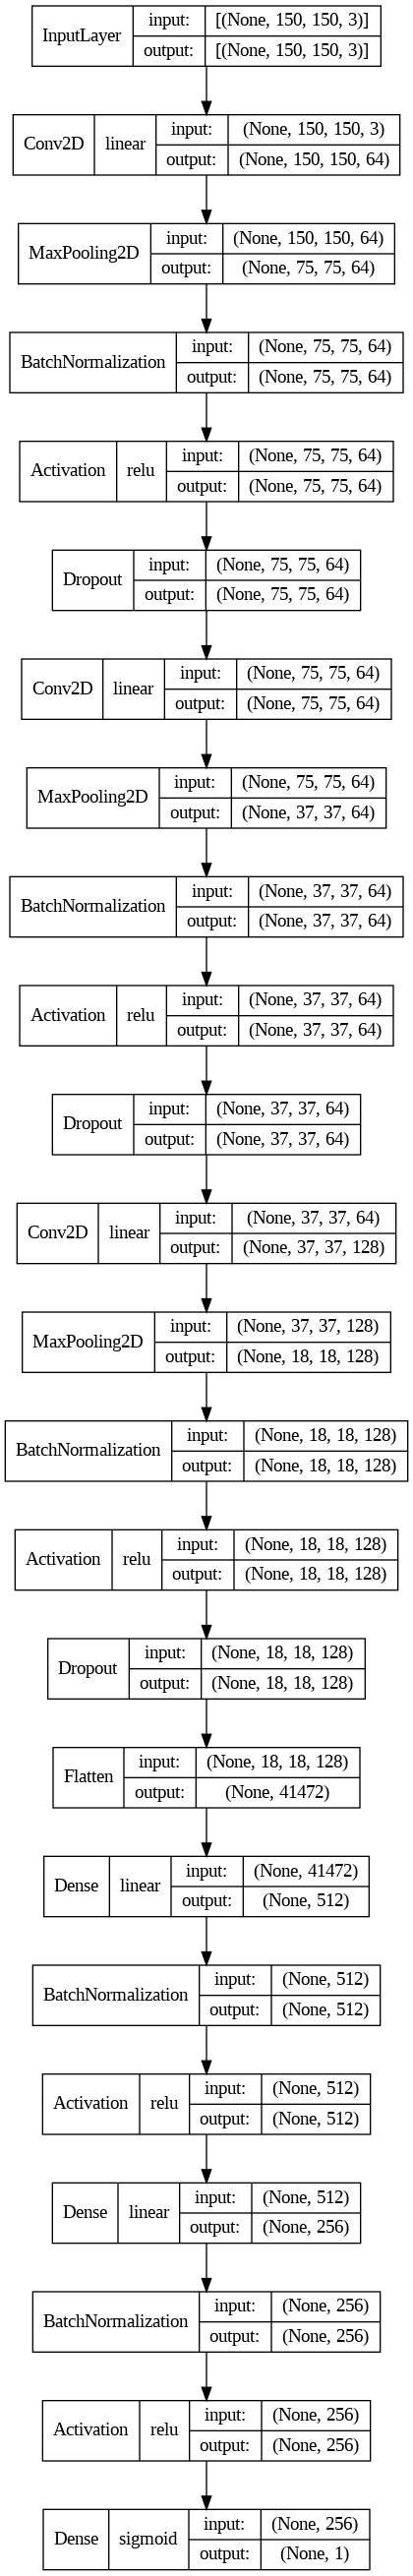

In [122]:
# Define the CNN model
layers_3 = Sequential()

# Convolutional Layer 1
layers_3.add(Conv2D(64, (3, 3), input_shape=(150, 150, 3), padding='same'))
layers_3.add(MaxPooling2D(pool_size=(2, 2)))
layers_3.add(BatchNormalization())
layers_3.add(Activation('relu'))
layers_3.add(Dropout(0.2))

# Convolutional Layer 2
layers_3.add(Conv2D(64, (3, 3), padding='same'))
layers_3.add(MaxPooling2D(pool_size=(2, 2)))
layers_3.add(BatchNormalization())
layers_3.add(Activation('relu'))
layers_3.add(Dropout(0.2))

# Convolutional Layer 3
layers_3.add(Conv2D(128, (3, 3), padding='same'))
layers_3.add(MaxPooling2D(pool_size=(2, 2)))
layers_3.add(BatchNormalization())
layers_3.add(Activation('relu'))
layers_3.add(Dropout(0.2))

# Flatten Layer
layers_3.add(Flatten())

# Fully Connected Layer 1
layers_3.add(Dense(512))
layers_3.add(BatchNormalization())
layers_3.add(Activation('relu'))

# Fully Connected Layer 2
layers_3.add(Dense(256))
layers_3.add(BatchNormalization())
layers_3.add(Activation('relu'))

# Output Layer
layers_3.add(Dense(1, activation='sigmoid'))

plot_model(layers_3, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [123]:
checkpoint_layers_3 = ModelCheckpoint('layers_3/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [124]:
layers_3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [125]:
history = layers_3.fit(X_train_4 , y_train_4, validation_split=0.25, epochs=50, batch_size=32, callbacks=[checkpoint_layers_3], verbose = 1)

Epoch 1/50
17/18 [===========================>..] - ETA: 0s - loss: 0.3560 - accuracy: 0.8566
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to layers_3/checkpoint
18/18 [==============================] - 9s 273ms/step - loss: 0.3546 - accuracy: 0.8577 - val_loss: 2.0123 - val_accuracy: 0.4000
Epoch 2/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0822 - accuracy: 0.9669
Epoch 2: val_accuracy did not improve from 0.40000
18/18 [==============================] - 1s 83ms/step - loss: 0.0845 - accuracy: 0.9658 - val_loss: 3.6212 - val_accuracy: 0.4000
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0309 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 0.40000
18/18 [==============================] - 2s 85ms/step - loss: 0.0313 - accuracy: 0.9964 - val_loss: 4.9711 - val_accuracy: 0.4000
Epoch 4/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0137 - accuracy: 0.9963
Epoch 4: val_accuracy did not improve from

In [126]:
best_layers_3 = load_model('layers_3/checkpoint')

loss, accuracy = best.evaluate(X_test, y_test, verbose=1)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

2/2 [==============================] - 0s 19ms/step - loss: 0.0078 - accuracy: 1.0000

Testing loss: 0.01, accuracy: 100.00%


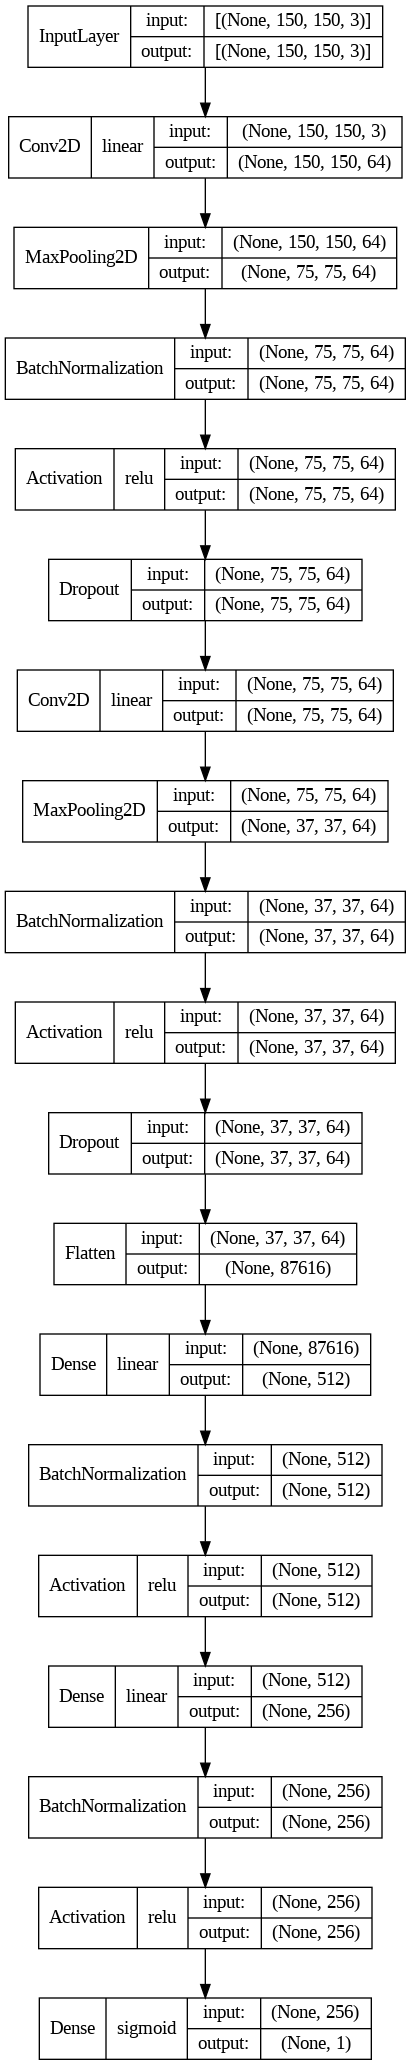

In [127]:
# Define the CNN model
layers_2 = Sequential()

# Convolutional Layer 1
layers_2.add(Conv2D(64, (3, 3), input_shape=(150, 150, 3), padding='same'))
layers_2.add(MaxPooling2D(pool_size=(2, 2)))
layers_2.add(BatchNormalization())
layers_2.add(Activation('relu'))
layers_2.add(Dropout(0.2))

# Convolutional Layer 2
layers_2.add(Conv2D(64, (3, 3), padding='same'))
layers_2.add(MaxPooling2D(pool_size=(2, 2)))
layers_2.add(BatchNormalization())
layers_2.add(Activation('relu'))
layers_2.add(Dropout(0.2))

# Flatten Layer
layers_2.add(Flatten())

# Fully Connected Layer 1
layers_2.add(Dense(512))
layers_2.add(BatchNormalization())
layers_2.add(Activation('relu'))

# Fully Connected Layer 2
layers_2.add(Dense(256))
layers_2.add(BatchNormalization())
layers_2.add(Activation('relu'))

# Output Layer
layers_2.add(Dense(1, activation='sigmoid'))

plot_model(layers_2, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [128]:
checkpoint_layers_2 = ModelCheckpoint('layers_2/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [129]:
layers_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [130]:
history = layers_2.fit(X_train_4 , y_train_4, validation_split=0.25, epochs=50, batch_size=32, callbacks=[checkpoint_layers_2], verbose = 1)

Epoch 1/50
17/18 [===========================>..] - ETA: 0s - loss: 0.2969 - accuracy: 0.8529
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to layers_2/checkpoint
18/18 [==============================] - 9s 363ms/step - loss: 0.2954 - accuracy: 0.8541 - val_loss: 1.3531 - val_accuracy: 0.4000
Epoch 2/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0766 - accuracy: 0.9816
Epoch 2: val_accuracy did not improve from 0.40000
18/18 [==============================] - 2s 87ms/step - loss: 0.0754 - accuracy: 0.9820 - val_loss: 2.1971 - val_accuracy: 0.4000
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0359 - accuracy: 0.9908
Epoch 3: val_accuracy did not improve from 0.40000
18/18 [==============================] - 2s 85ms/step - loss: 0.0353 - accuracy: 0.9910 - val_loss: 3.2101 - val_accuracy: 0.4000
Epoch 4/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0305 - accuracy: 0.9926
Epoch 4: val_accuracy did not improve from

In [131]:
best_layers_2 = load_model('layers_2/checkpoint')

loss, accuracy = best.evaluate(X_test, y_test, verbose=1)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

2/2 [==============================] - 0s 16ms/step - loss: 0.0078 - accuracy: 1.0000

Testing loss: 0.01, accuracy: 100.00%


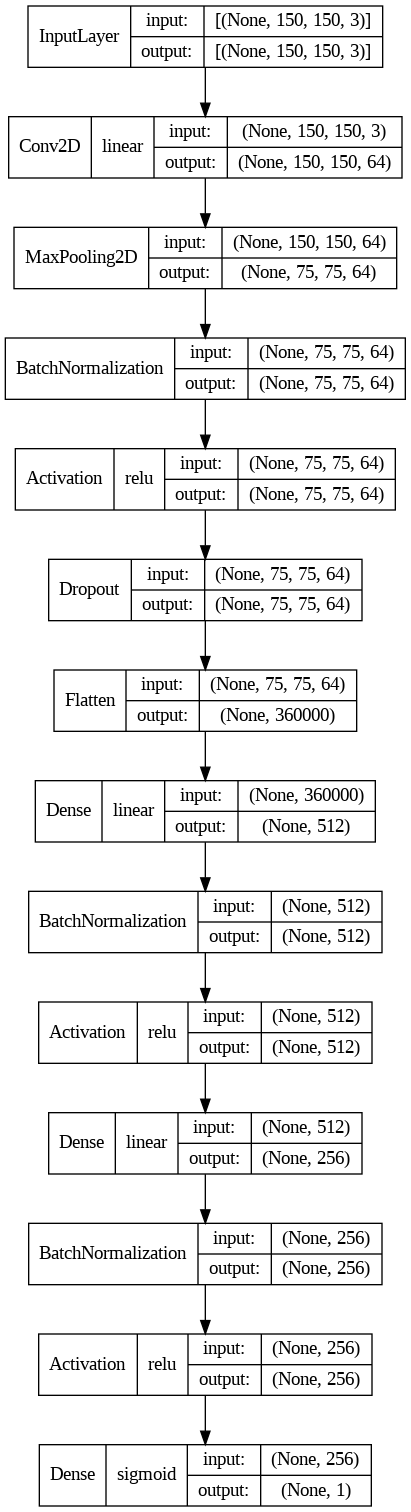

In [132]:
# Define the CNN model
layers_1 = Sequential()

# Convolutional Layer 1
layers_1.add(Conv2D(64, (3, 3), input_shape=(150, 150, 3), padding='same'))
layers_1.add(MaxPooling2D(pool_size=(2, 2)))
layers_1.add(BatchNormalization())
layers_1.add(Activation('relu'))
layers_1.add(Dropout(0.2))

# Flatten Layer
layers_1.add(Flatten())

# Fully Connected Layer 1
layers_1.add(Dense(512))
layers_1.add(BatchNormalization())
layers_1.add(Activation('relu'))

# Fully Connected Layer 2
layers_1.add(Dense(256))
layers_1.add(BatchNormalization())
layers_1.add(Activation('relu'))

# Output Layer
layers_1.add(Dense(1, activation='sigmoid'))

plot_model(layers_1, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [133]:
checkpoint_layers_1 = ModelCheckpoint('layers_1/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [134]:
layers_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [135]:
history = layers_1.fit(X_train_4 , y_train_4, validation_split=0.25, epochs=50, batch_size=32, callbacks=[checkpoint_layers_1], verbose = 1)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8306
Epoch 1: val_accuracy improved from -inf to 0.42162, saving model to layers_1/checkpoint
18/18 [==============================] - 24s 1s/step - loss: 0.4058 - accuracy: 0.8306 - val_loss: 0.8136 - val_accuracy: 0.4216
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9459
Epoch 2: val_accuracy did not improve from 0.42162
18/18 [==============================] - 2s 119ms/step - loss: 0.1676 - accuracy: 0.9459 - val_loss: 1.0166 - val_accuracy: 0.4000
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9820
Epoch 3: val_accuracy did not improve from 0.42162
18/18 [==============================] - 2s 103ms/step - loss: 0.0748 - accuracy: 0.9820 - val_loss: 1.0428 - val_accuracy: 0.4000
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9946
Epoch 4: val_accuracy did not improve from

In [136]:
best_layers_1 = load_model('layers_1/checkpoint')

loss, accuracy = best.evaluate(X_test, y_test, verbose=1)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

2/2 [==============================] - 0s 15ms/step - loss: 0.0078 - accuracy: 1.0000

Testing loss: 0.01, accuracy: 100.00%
